In [ ]:
from google.colab import drive
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from google.colab import drive


In [ ]:
# Google Drive'ı bağla
drive.mount('/content/drive')

# Veri yollarını tanımla
dataset_path = "/content/drive/MyDrive/dataset"
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "validation")
test_dir = os.path.join(dataset_path, "test")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Parametreler
img_size = (299, 299)
batch_size = 1024

# Datasetleri yükle
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

val_ds = image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

# Sınıf isimleri
class_names = train_ds.class_names
num_classes = len(class_names)


Found 6739 files belonging to 3 classes.
Found 1685 files belonging to 3 classes.
Found 2106 files belonging to 3 classes.


In [ ]:
# Performans için optimize
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Model
base_model = InceptionV3(input_shape=(299, 299, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

In [ ]:
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(299, 299, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,328,099 (85.17 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [ ]:
# Eğitim
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 309s 33s/step - accuracy: 0.5501 - loss: 0.9539 - val_accuracy: 0.8493 - val_loss: 0.3998
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8522 - loss: 0.3947 - val_accuracy: 0.9003 - val_loss: 0.2883
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8955 - loss: 0.2754 - val_accuracy: 0.9175 - val_loss: 0.2279
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9174 - loss: 0.2244 - val_accuracy: 0.9110 - val_loss: 0.2207
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9202 - loss: 0.2126 - val_accuracy: 0.9252 - val_loss: 0.1996
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9260 - loss: 0.1923 - val_accuracy: 0.9276 - val_loss: 0.1895
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9340 - loss: 0.1762 - val_accuracy: 0.9264 - val_loss: 0.1858
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9377 - loss: 0.1668 - val_accuracy: 0.9282 - val_loss: 0.179

In [ ]:
# Modeli kaydet
model.save("inceptionv3.h5")

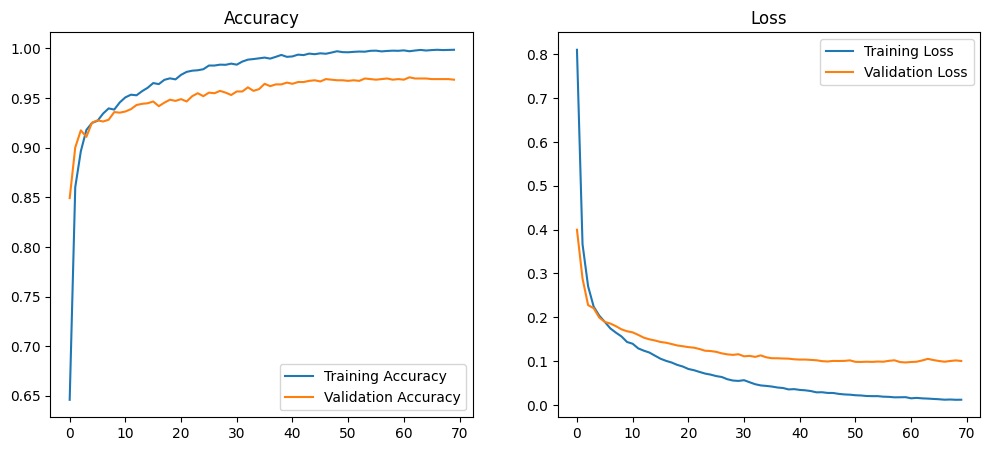

In [ ]:
# Eğitim geçmişi grafikleri
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

plot_history(history)

In [ ]:
# Test performansı
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 138s 36s/step - accuracy: 0.9774 - loss: 0.0668
Test Accuracy: 0.9758


In [ ]:
# Tahminler
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

print("\nSınıflandırma Raporu:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step

Sınıflandırma Raporu:

              precision    recall  f1-score   support

       glass       0.98      0.98      0.98      1010
       paper       0.98      0.99      0.99       540
     plastic       0.97      0.95      0.96       556

    accuracy                           0.98      2106
   macro avg       0.98      0.97      0.97      2106
weighted avg       0.98      0.98      0.98      2106



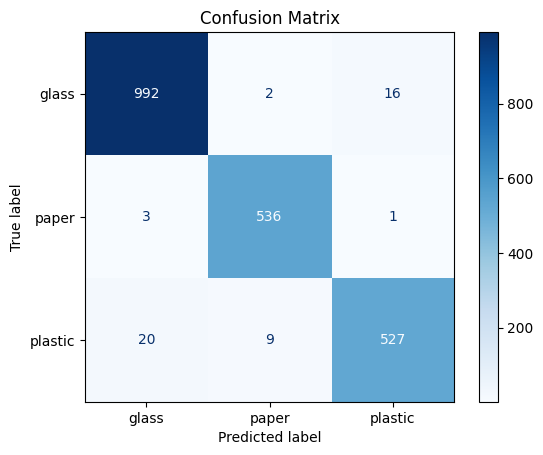

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()